In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

pd.options.mode.chained_assignment = None  # default='warn'
ROOT = os.path.dirname(os.getcwd())

# Outline
Here, we will perform a computation to analyse the advance ratio for each performance. This is the ratio of passes in the lateral direction to the ratio in the vertical direction - thus it measures passing "directness". Finally, we will try to relate it to performance

In [2]:
events = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'events_df.pkl.gz'))
events_passing = events.loc[events['eventName']=='Pass']

#X=100 => Opponent's Goal; Y=100 =>Right Side
#Looking at all passes for now, not exclusively sucessful ones

events_passing['delta_y'] = events_passing['positions'].apply(lambda row: row[1]['y'] - row[0]['y'])
events_passing['delta_x'] = events_passing['positions'].apply(lambda row: row[1]['x'] - row[0]['x'])

events_passing = events_passing.loc[events_passing['tags'].apply(lambda row: sum([elem['id']==1801 for elem in row])>=1)]


events_passing

eventId subEventName            tags  playerId  \
Italy 0             8  Simple pass  [{'id': 1801}]      8327   
      1             8  Simple pass  [{'id': 1801}]     20438   
      5             8  Simple pass  [{'id': 1801}]      8306   
      10            8  Simple pass  [{'id': 1801}]     86366   
      14            8  Simple pass  [{'id': 1801}]      8306   
...               ...          ...             ...       ...   
Spain 628641        8  Simple pass  [{'id': 1801}]    286994   
      628650        8    Hand pass  [{'id': 1801}]      3486   
      628652        8  Simple pass  [{'id': 1801}]      3695   
      628654        8  Simple pass  [{'id': 1801}]     20623   
      628657        8  Simple pass  [{'id': 1801}]     40756   

                                             positions  matchId eventName  \
Italy 0       [{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]  2575959      Pass   
      1       [{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]  2575959      Pass   
      5       [{'y': 15, 'x': 72}, {'y': 25, 'x': 72}]  2575959      Pass   
      10      [{'y': 82, 'x': 38}, {'y': 88, 'x': 43}]  2575959      Pass   
      14      [{'y': 15, 'x': 61}, {'y': 15, 'x': 37}]  2575959      Pass   
...                                                ...      ...       ...   
Spain 628641    [{'y': 6, 'x': 27}, {'y': 4, 'x': 40}]  2565927      Pass   
      628650   [{'y': 29, 'x': 8}, {'y': 19, 'x': 14}]  2565927      Pass   
      628652  [{'y': 34, 'x': 36}, {'y': 52, 'x': 45}]  2565927      Pass   
      628654   [{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]  2565927      Pass   
      628657    [{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]  2565927      Pass   

              teamId matchPeriod     eventSec subEventId         id  delta_y  \
Italy 0         3158          1H     2.530536         85  180423957       -8   
      1         3158          1H     3.768418         85  180423958      -27   
      5         3158          1H    10.376066         85  180423962       10   
      10        3172          1H    16.240563         85  180423979        6   
      14        3158          1H    19.153235         85  180423968        0   
...              ...         ...          ...        ...        ...      ...   
Spain 628641     682          2H  2876.959208         85  253302651       -2   
      628650     682          2H  2925.547631         81  253302662      -10   
      628652     682          2H  2931.782904         85  253302665       18   
      628654     682          2H  2939.077491         85  253302671      -23   
      628657     675          2H  2943.089232         85  253302698      -18   

              delta_x  
Italy 0            -6  
      1            -7  
      5             0  
      10            5  
      14          -24  
...               ...  
Spain 628641       13  
      628650        6  
      628652        9  
      628654       22  
      628657        1  

[1296476 rows x 14 columns]

In [3]:
tmp = events_passing[['delta_y', 'delta_x', 'matchId', 'teamId']].abs().groupby(by=['matchId', 'teamId']).sum()
tmp['advance_ratio'] = tmp['delta_y']/tmp['delta_x']
tmp = tmp[['advance_ratio']]
advance_ratio = tmp.copy()

match_stats = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'matches_goals_wins.pkl.gz'))
tmp = pd.concat([tmp, match_stats], axis=1)
errors = tmp.groupby(tmp.index.get_level_values(1)).sem()
tmp=tmp.mean(level=1)

performance = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'team_performance.pkl.gz'))
tmp = pd.concat([tmp, performance], axis=1)
tmp.head()

,advance_ratio,goals,win,name,city,area.name,avg_pass_per_game,avg_shots_per_game,avg_goals_per_game,end_of_season_pts
674,1.706035,1.710526,0.578947,Valencia,Valencia,Spain,413.789474,11.000000,1.421053,73
675,1.784264,2.473684,0.578947,Real Madrid,Madrid,Spain,581.078947,16.605263,2.131579,76
676,1.796884,2.605263,0.736842,Barcelona,Barcelona,Spain,612.105263,13.210526,2.289474,93
677,1.554460,1.000000,0.157895,Deportivo La Coru\u00f1a,A Coru\u00f1a,Spain,382.605263,10.657895,0.921053,29
678,1.492390,1.078947,0.263158,Athletic Club,Bilbao,Spain,395.315789,9.921053,0.842105,43


<Figure size 1080x360 with 0 Axes>

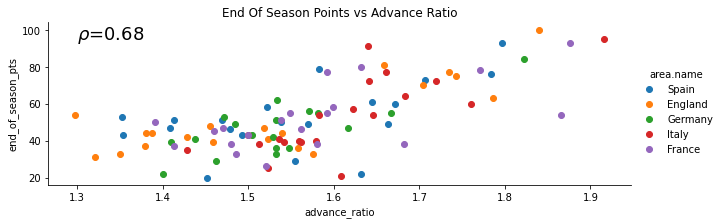

In [4]:
import seaborn
from matplotlib import pyplot 
#from ggplot import *

plt.figure(figsize=(15, 5))
fg = seaborn.FacetGrid(data=tmp, hue='area.name', hue_order=tmp['area.name'].unique(), aspect=3)
fg.map(pyplot.scatter, 'advance_ratio', 'end_of_season_pts').add_legend()
plt.title('End Of Season Points vs Advance Ratio')
plt.text(1.3, 95,'$\\rho$=0.68', fontsize=18)
plt.savefig('../figures/advance_ratio_performance_EOS_pts', bbox_inches='tight')

plt.show()


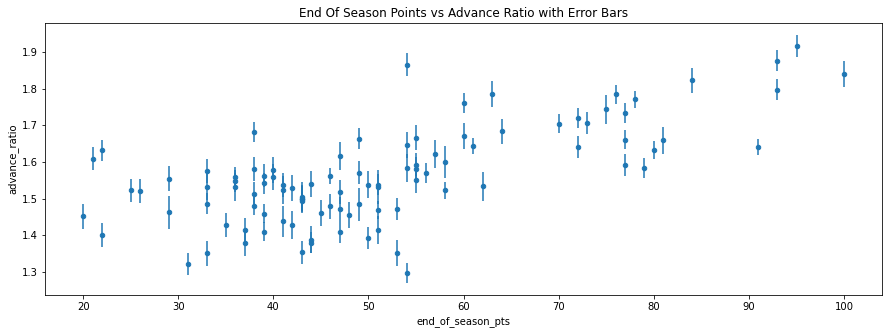

In [5]:
tmp[['advance_ratio', 'end_of_season_pts']].plot(kind='scatter', x='end_of_season_pts', y='advance_ratio', yerr=errors[['advance_ratio']], figsize=(15, 5))
plt.title('End Of Season Points vs Advance Ratio with Error Bars')
plt.savefig('../figures/advance_ratio_performance_EOS_pts_ERROR', bbox_inches='tight')

In [6]:
tmp[['advance_ratio', 'end_of_season_pts']].corr()

,advance_ratio,end_of_season_pts
advance_ratio,1.000000,0.679284
end_of_season_pts,0.679284,1.000000


In [9]:
advance_ratio.to_pickle(os.path.join(ROOT, 'intermediates', 'advance_ratio.pkl.gz'))
advance_ratio.to_csv(os.path.join(ROOT, 'intermediates', 'advance_ratio.csv'))